# Using Long Short Term Memory networks to predict visibility for use in aviation weather forecasting 




A model has been developed to help meteorologists make fast and accurate visibility predictions.

LSTM has been trained on historical weather data for Dublin Airport obtained from the Met Eireann historical 
archive https://www.met.ie/climate/available-data/historical-data

A forecast window of 6 hours shall be used in line with Terminal Aviation Forecasts (TAF) updates.

This is a regression task with dependent variable vis (m) 

## 1. Description of data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
url = 'https://raw.githubusercontent.com/RobJoscelyne/EIDW_WX/main/dub_wx.csv' # Dataset on github
wx = pd.read_csv(url)

<ipython-input-1-f9c383c682fa>:8: DtypeWarning: Columns (8,9,14) have mixed types. Specify dtype option on import or set low_memory=False.
  wx = pd.read_csv(url)


# Index for weather codes downloaded with dataset 
Met Eireann (2022)

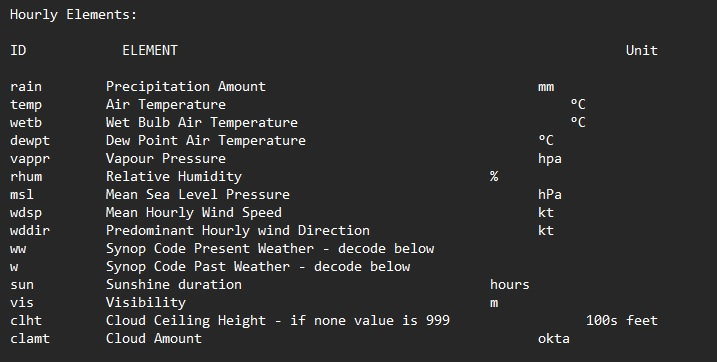

In [2]:
from IPython.display import Image
Image(filename='index1.jpg') 

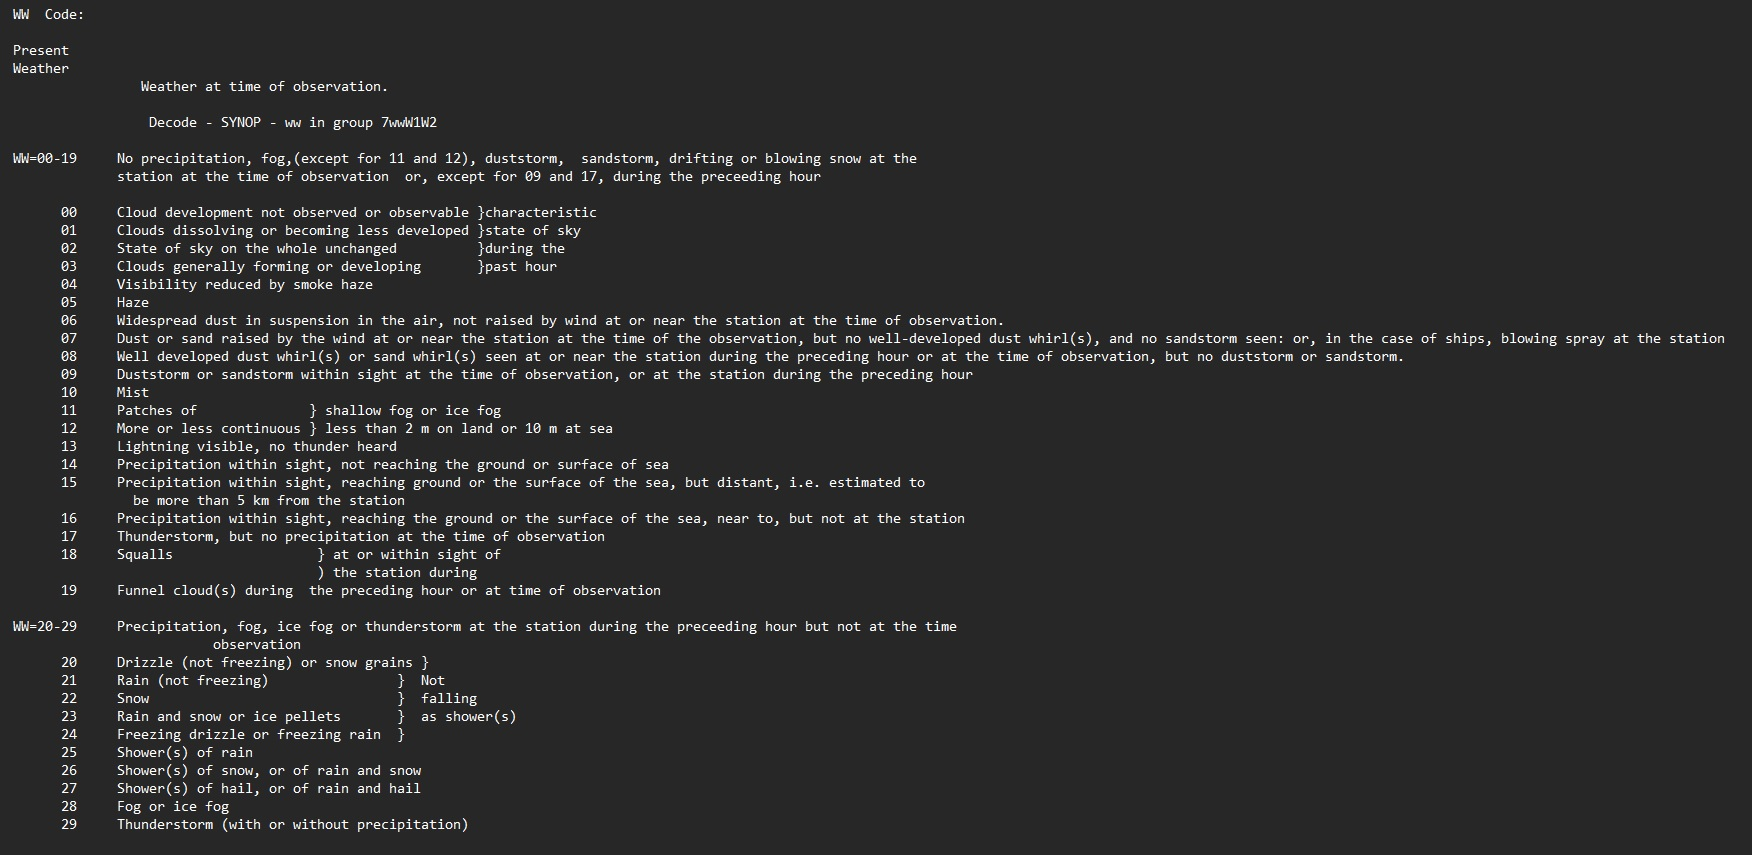

In [3]:
Image(filename='index2.jpg') 

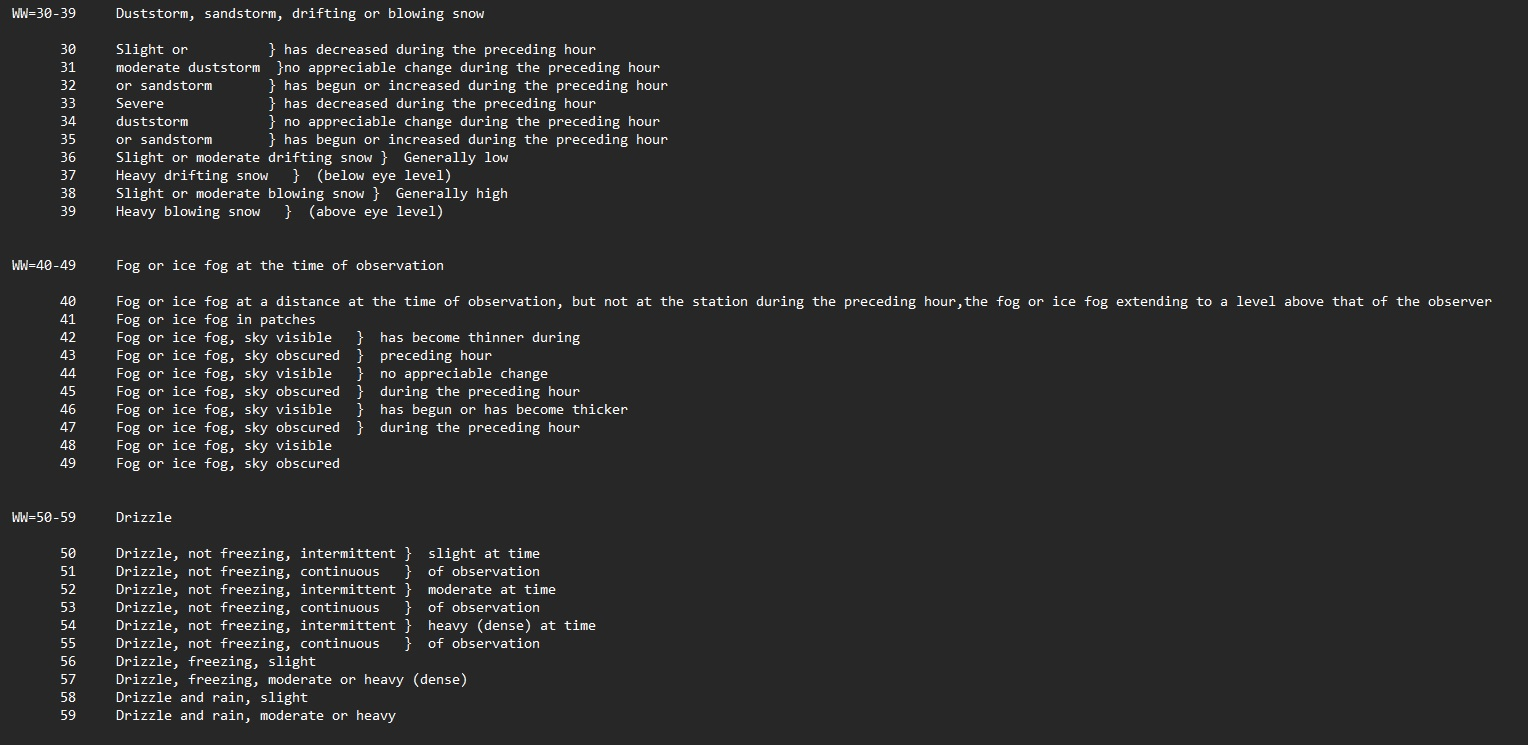

In [4]:
Image(filename='index3.jpg') 

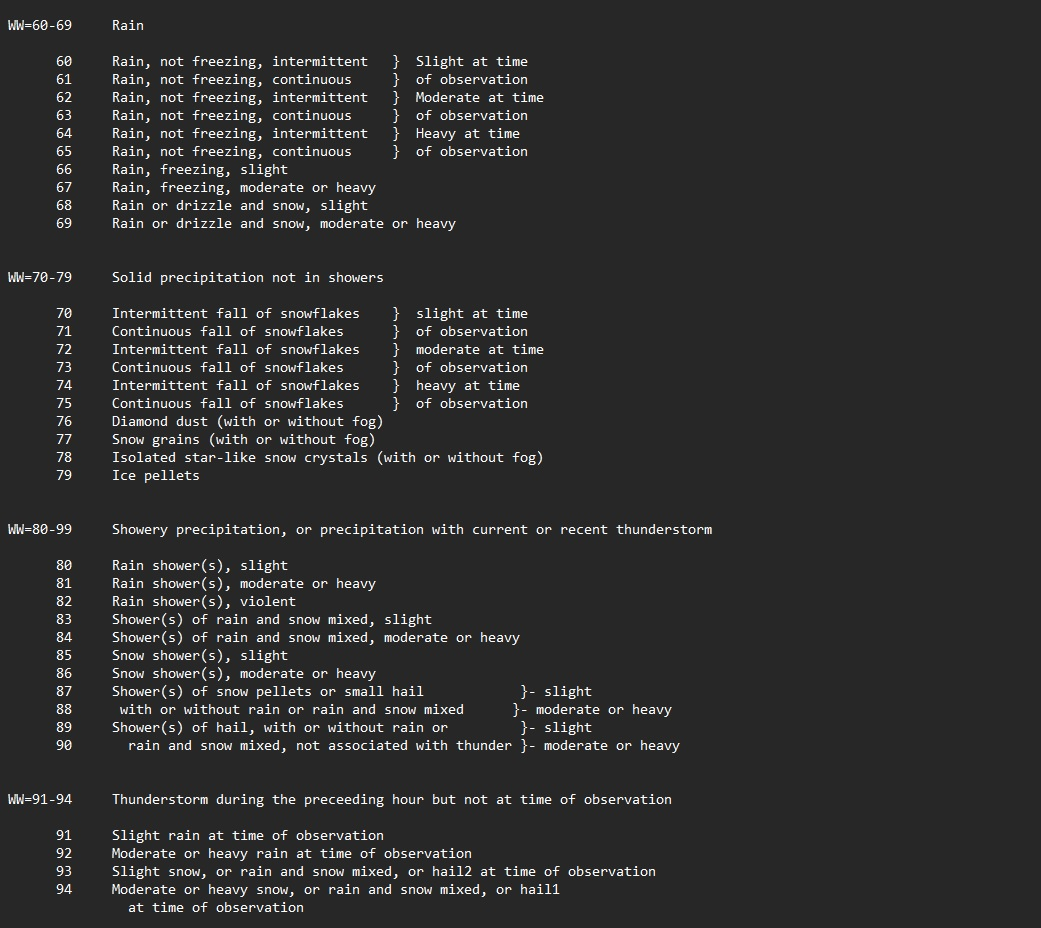

In [5]:
Image(filename='index4.jpg') 

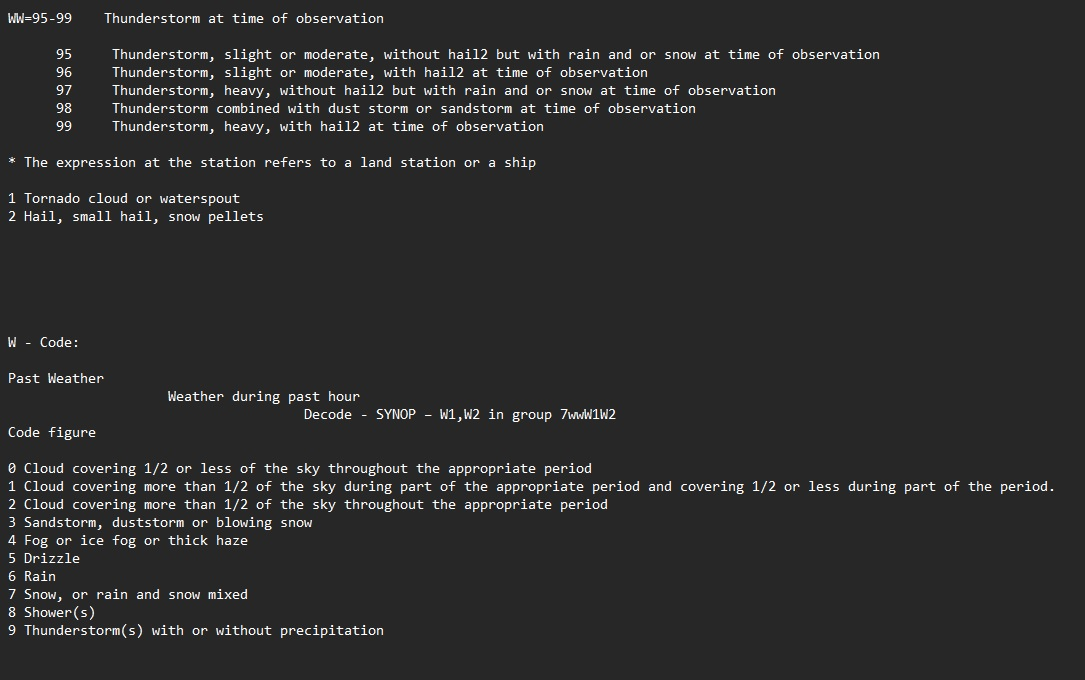

In [6]:
Image(filename='index5.jpg') 

In [7]:
wx.head()

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,...,ind.3,wdsp,ind.4,wddir,ww,w,sun,vis,clht,clamt
0,01/01/1992 00:00,0,0.0,0,8.4,0,6.6,4.3,8.3,75,...,2,23,2,210,2,11,0.0,25000,999,3
1,01/01/1992 01:00,0,0.0,0,8.6,0,6.6,4.0,8.1,73,...,2,23,2,220,2,11,0.0,25000,100,6
2,01/01/1992 02:00,0,0.0,0,9.0,0,7.0,4.5,8.4,73,...,2,22,2,220,2,11,0.0,25000,100,6
3,01/01/1992 03:00,0,0.0,0,9.5,0,7.4,4.8,8.6,73,...,2,22,2,220,2,11,0.0,25000,25,6
4,01/01/1992 04:00,0,0.0,0,9.5,0,7.4,4.8,8.6,73,...,2,23,2,230,2,11,0.0,25000,25,6


In [8]:
#Dimensions of dataset
wx.shape

(262993, 21)

In [9]:
wx.describe()

,ind,rain,ind.1,temp,ind.2,wetb,dewpt,msl,ind.3,wdsp,ind.4,ww,w,sun,vis,clht,clamt
count,262993.000000,262993.000000,262993.000000,262993.000000,262993.000000,262993.00000,262993.000000,262993.000000,262993.000000,262993.000000,262993.000000,262993.000000,262993.000000,262993.000000,262993.000000,262993.000000,262993.000000
mean,0.541052,0.088057,0.020636,9.759027,0.029054,8.37888,6.853009,1013.512605,2.000783,10.466009,2.000913,15.017263,29.865917,0.168221,27459.489625,299.054340,5.584054
std,1.027455,0.422269,0.142161,4.952152,0.190849,4.40511,4.462969,12.372267,0.049479,5.471804,0.053394,22.333332,27.060556,0.327046,14734.375450,410.173509,2.367263
min,0.000000,0.000000,0.000000,-11.500000,0.000000,-49.90000,-11.700000,954.300000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,5.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,6.200000,0.000000,5.20000,3.600000,1005.900000,2.000000,6.000000,2.000000,2.000000,11.000000,0.000000,18000.000000,25.000000,4.000000
50%,0.000000,0.000000,0.000000,9.800000,0.000000,8.60000,7.000000,1014.600000,2.000000,10.000000,2.000000,2.000000,11.000000,0.000000,25000.000000,50.000000,7.000000
75%,0.000000,0.000000,0.000000,13.300000,0.000000,11.70000,10.200000,1022.100000,2.000000,14.000000,2.000000,21.000000,62.000000,0.100000,40000.000000,999.000000,7.000000
max,4.000000,26.500000,1.000000,26.900000,5.000000,21.40000,20.000000,1048.200000,6.000000,45.000000,7.000000,97.000000,98.000000,1.000000,75000.000000,999.000000,9.000000


In [10]:
#Data types included in dataset
#The wx dataset features categorical variables. Before the modelling stage these categorical values will need to be converted to numerical.
wx.dtypes

date      object
ind        int64
rain     float64
ind.1      int64
temp     float64
ind.2      int64
wetb     float64
dewpt    float64
vappr     object
rhum      object
msl      float64
ind.3      int64
wdsp       int64
ind.4      int64
wddir     object
ww         int64
w          int64
sun      float64
vis        int64
clht       int64
clamt      int64
dtype: object

In [11]:
#wddir (wind direction) vappr (vapour pressure) and rhum (relative humidity) are all numerical values but have been entered as string in dataset. 
#Therefore convert from object to float for outlier analysis later.

In [12]:
wx['rhum'] = pd.to_numeric(wx['rhum'], errors='coerce' )

In [13]:
wx['vappr'] = pd.to_numeric(wx['vappr'], errors='coerce')

In [14]:
wx['wddir'] = pd.to_numeric(wx['wddir'], errors='coerce')

In [15]:
#All numerical features have been converted
wx.dtypes

date      object
ind        int64
rain     float64
ind.1      int64
temp     float64
ind.2      int64
wetb     float64
dewpt    float64
vappr    float64
rhum     float64
msl      float64
ind.3      int64
wdsp       int64
ind.4      int64
wddir    float64
ww         int64
w          int64
sun      float64
vis        int64
clht       int64
clamt      int64
dtype: object

# 2. Checking for missing values

In [16]:
#Checking for missing values
for var in wx.columns:
    print(var, 'has \t\t\t', wx[var].isna().sum(), ' missing values')

date has 			 0  missing values
ind has 			 0  missing values
rain has 			 0  missing values
ind.1 has 			 0  missing values
temp has 			 0  missing values
ind.2 has 			 0  missing values
wetb has 			 0  missing values
dewpt has 			 0  missing values
vappr has 			 1  missing values
rhum has 			 1  missing values
msl has 			 0  missing values
ind.3 has 			 0  missing values
wdsp has 			 0  missing values
ind.4 has 			 0  missing values
wddir has 			 2  missing values
ww has 			 0  missing values
w has 			 0  missing values
sun has 			 0  missing values
vis has 			 0  missing values
clht has 			 0  missing values
clamt has 			 0  missing values


In [17]:
#Lets investigate the 4 missing values 
wx[wx.isnull().any(axis=1)]

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,...,ind.3,wdsp,ind.4,wddir,ww,w,sun,vis,clht,clamt
59044,26/09/1998 04:00,0,0.2,0,13.7,0,13.7,13.7,NaN,NaN,...,2,10,2,50.0,60,64,0.0,1300,3,8
136218,16/07/2007 18:00,0,0.0,0,17.8,0,14.5,11.9,13.9,68.0,...,2,10,7,NaN,15,98,0.5,30000,90,5
262834,25/12/2021 10:00,0,1.2,0,7.7,0,7.3,6.8,9.9,94.0,...,2,17,7,NaN,60,62,0.0,7000,9,8


In [18]:
wx.iloc[59042:59048] #Look at the sequence of values before and after missing values for vappr and rhum

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,...,ind.3,wdsp,ind.4,wddir,ww,w,sun,vis,clht,clamt
59042,26/09/1998 02:00,0,1.4,0,13.8,0,13.8,13.8,15.8,100.0,...,2,7,2,60.0,61,64,0.0,800,3,8
59043,26/09/1998 03:00,0,0.2,0,13.7,0,13.7,13.7,15.7,100.0,...,2,8,2,50.0,60,64,0.0,800,3,8
59044,26/09/1998 04:00,0,0.2,0,13.7,0,13.7,13.7,NaN,NaN,...,2,10,2,50.0,60,64,0.0,1300,3,8
59045,26/09/1998 05:00,0,0.1,0,13.6,0,13.6,13.6,15.6,100.0,...,2,10,2,50.0,58,65,0.0,1600,3,8
59046,26/09/1998 06:00,2,0.0,0,13.4,0,13.4,13.4,15.4,100.0,...,2,11,2,40.0,21,54,0.0,2600,5,8
59047,26/09/1998 07:00,2,0.0,0,13.6,0,13.6,13.6,15.6,100.0,...,2,13,2,50.0,21,65,0.0,1700,7,8


In [19]:
#Air pressure is dropping before and after the missing value. The wind speed is increasing as the pressure reduces. 
#This is caused by the air moving into a lower pressure area to correct the imbalance of a pressure gradient. Therefore 15.65 which would be 
#inline with the theory.
wx.at[59044,'vappr']=15.65

In [20]:
#When Relative Humidity is 100% rain is highly likely because the air cannot hold anymore moisture i.e. 100% saturated. 
#The missing value occured during rain so it would be reasonable to assume 100% can be imputed in rhum. 
wx.at[59044,'rhum']=100

In [21]:
wx.iloc[262832:262838] #Look at the sequence of values before and after missing value 1 of 2 wind direction (wddir)

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,...,ind.3,wdsp,ind.4,wddir,ww,w,sun,vis,clht,clamt
262832,25/12/2021 08:00,0,0.2,0,8.0,0,7.4,6.8,9.8,92.0,...,2,16,2,110.0,58,65,0.0,9000,10,7
262833,25/12/2021 09:00,0,1.4,0,7.8,0,7.4,6.9,10.0,94.0,...,2,17,2,110.0,60,65,0.0,5000,12,8
262834,25/12/2021 10:00,0,1.2,0,7.7,0,7.3,6.8,9.9,94.0,...,2,17,7,NaN,60,62,0.0,7000,9,8
262835,25/12/2021 11:00,0,0.7,0,7.9,0,7.3,6.7,9.7,91.0,...,2,17,2,110.0,58,65,0.0,7000,13,8
262836,25/12/2021 12:00,0,1.4,0,7.8,0,7.3,6.8,9.8,93.0,...,2,17,2,110.0,60,65,0.0,5000,13,8
262837,25/12/2021 13:00,0,2.4,0,7.9,0,7.5,7.1,10.0,94.0,...,2,16,2,120.0,63,66,0.0,5000,11,8


In [22]:
wx.iloc[136216:136222] #Look at the sequence of values before and after missing value 2 of 2 wind direction (wddir)

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,...,ind.3,wdsp,ind.4,wddir,ww,w,sun,vis,clht,clamt
136216,16/07/2007 16:00,0,0.0,0,19.6,0,15.4,12.2,14.1,62.0,...,2,11,2,220.0,2,11,0.8,30000,50,4
136217,16/07/2007 17:00,0,0.0,0,18.1,0,14.3,11.2,13.3,64.0,...,2,15,2,210.0,2,11,0.4,30000,70,5
136218,16/07/2007 18:00,0,0.0,0,17.8,0,14.5,11.9,13.9,68.0,...,2,10,7,NaN,15,98,0.5,30000,90,5
136219,16/07/2007 19:00,0,0.0,0,17.6,0,14.2,11.4,13.5,67.0,...,2,5,2,210.0,2,11,0.6,30000,90,4
136220,16/07/2007 20:00,0,0.0,0,16.4,0,13.6,11.3,13.3,71.0,...,2,5,2,260.0,2,11,0.2,35000,40,5
136221,16/07/2007 21:00,0,0.0,0,14.6,0,12.6,10.9,13.0,78.0,...,2,6,2,230.0,2,11,0.0,35000,999,3


In [23]:
#The wind is consistently from the south east (110 degrees) in the hours before and after the missing value.
#Wind speed (wdsp) is 17kts before and after the missing value that would indicate the direction of wind is steady. A value of 110 would seem sensible  
wx.at[262834,'wddir']=110

In [24]:
#The wind is mainly from the south west in the hours before and after the missing value.
#Wind speed (wdsp) is chanagable and would indicate an alteration in wind direction. Lets impute 220 to take into account for the chanagability.  
wx.at[136218,'wddir']=220

In [25]:
#Missing values have been imputed
for var in wx.columns:
    print(var, 'has \t\t\t', wx[var].isna().sum(), ' missing values')

date has 			 0  missing values
ind has 			 0  missing values
rain has 			 0  missing values
ind.1 has 			 0  missing values
temp has 			 0  missing values
ind.2 has 			 0  missing values
wetb has 			 0  missing values
dewpt has 			 0  missing values
vappr has 			 0  missing values
rhum has 			 0  missing values
msl has 			 0  missing values
ind.3 has 			 0  missing values
wdsp has 			 0  missing values
ind.4 has 			 0  missing values
wddir has 			 0  missing values
ww has 			 0  missing values
w has 			 0  missing values
sun has 			 0  missing values
vis has 			 0  missing values
clht has 			 0  missing values
clamt has 			 0  missing values


Drop ind columns. These include codes that feature text comments about the independent variables. The analysis will focus on numerical and categorical data. Therefore ind columns can be dropped. 

In [26]:
wx = wx.drop(['ind', 'ind.1', 'ind.2', 'ind.3', 'ind.4'],axis=1)

## 3. Checking for outliers

Dependent variable - visibility

<AxesSubplot:xlabel='vis'>

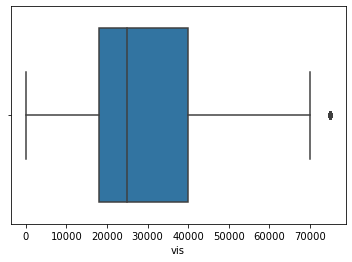

In [27]:
sns.boxplot(x=wx['vis'])

Independent variables

<AxesSubplot:xlabel='rain'>

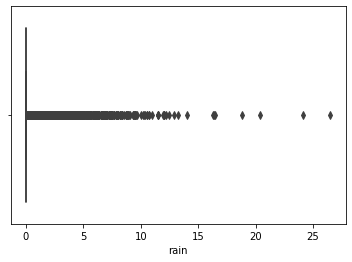

In [28]:
sns.boxplot(x=wx['rain'])

<AxesSubplot:xlabel='temp'>

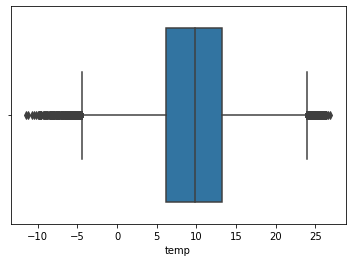

In [29]:
sns.boxplot(x=wx['temp'])

<AxesSubplot:xlabel='wetb'>

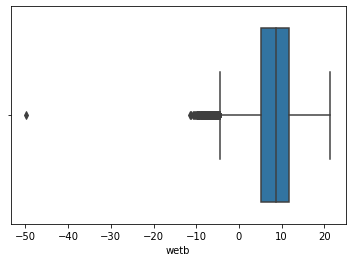

In [30]:
sns.boxplot(x=wx['wetb'])

<AxesSubplot:xlabel='dewpt'>

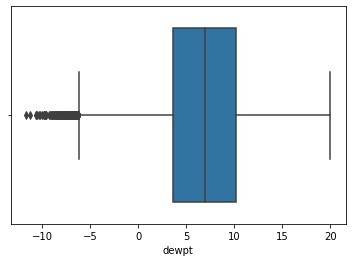

In [31]:
sns.boxplot(x=wx['dewpt'])

<AxesSubplot:xlabel='msl'>

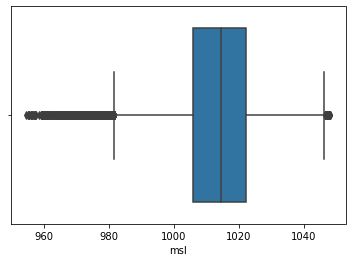

In [32]:
sns.boxplot(x=wx['msl'])

<AxesSubplot:xlabel='wdsp'>

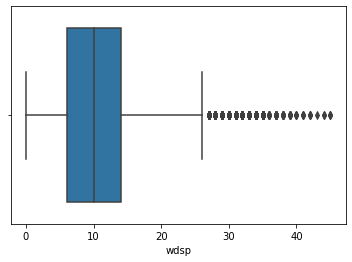

In [33]:
sns.boxplot(x=wx['wdsp'])

<AxesSubplot:xlabel='w'>

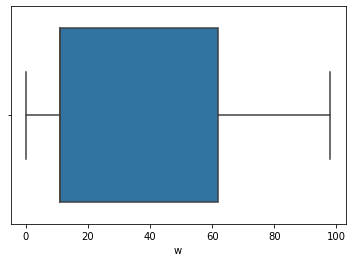

In [34]:
sns.boxplot(x=wx['w'])

<AxesSubplot:xlabel='ww'>

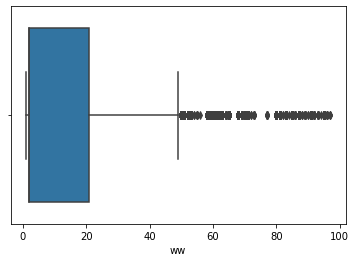

In [35]:
sns.boxplot(x=wx['ww'])

<AxesSubplot:xlabel='sun'>

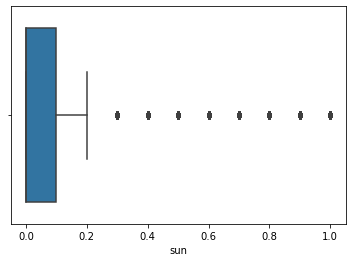

In [36]:
sns.boxplot(x=wx['sun'])

<AxesSubplot:xlabel='clht'>

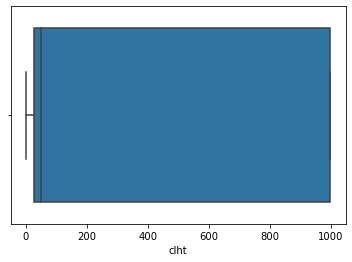

In [37]:
sns.boxplot(x=wx['clht'])

<AxesSubplot:xlabel='clamt'>

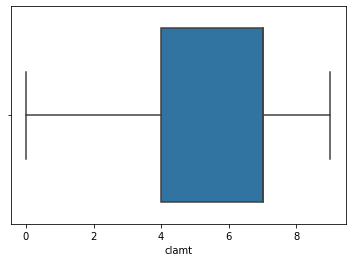

In [38]:
sns.boxplot(x=wx['clamt'])

<AxesSubplot:xlabel='rhum'>

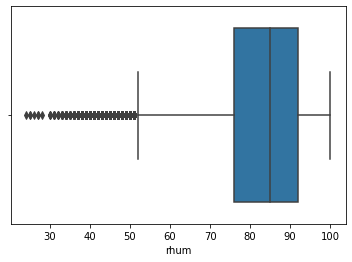

In [39]:
sns.boxplot(x=wx['rhum'])

<AxesSubplot:xlabel='wddir'>

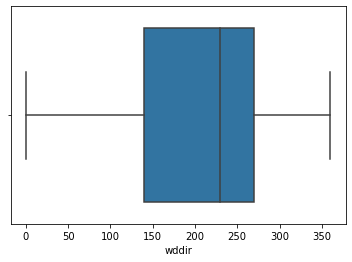

In [40]:
sns.boxplot(x=wx['wddir'])

<AxesSubplot:xlabel='vappr'>

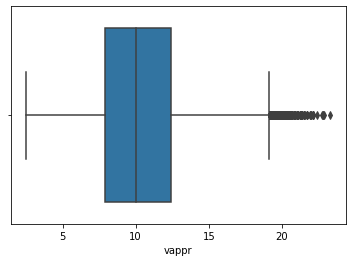

In [41]:
sns.boxplot(x=wx['vappr'])

Mulitple outliers have been detected. All values were checked and are within the normal range for Irish weather, therefore no outliers will be removed.

## 4. Using t-test for feature selection

In [42]:
#Check model performance using linear regression
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

#deliniate target feature date from dataset 
X = wx.drop(['date','vis'], axis=1)

y=wx['vis']
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size = 0.2, random_state=5)


X = sm.add_constant(X_train_1)

model = sm.OLS(np.log(y_train_1),X)
results = model.fit()
y_pred=results.predict(X)

rms = np.sqrt(mean_squared_error(y_train_1, y_pred))
#

X_test = sm.add_constant(X_test_1)
y_test_pred=results.predict(X_test)
rms_test = np.sqrt(mean_squared_error(y_test_1, y_test_pred))
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    vis   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                 1.203e+04
Date:                Thu, 07 Apr 2022   Prob (F-statistic):               0.00
Time:                        19:21:52   Log-Likelihood:            -1.9020e+05
No. Observations:              210394   AIC:                         3.804e+05
Df Residuals:                  210379   BIC:                         3.806e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.9969      0.153    157.145      0.0

In [43]:
#The null hypothesis for F statistic is that the 2 models are equal. The alternative hypothesis is that 
#the intercept model is worse than the current model.  
#The p value of the F statistic is less than 0.05 and the F statistic is large (1.2e4) therefore we can
# reject the null hypothesis. This means there is evidence of a linear relationship between the independent variables and
#dependent variable.

#To determine if relevent to the target we perform a t-test. The t-test pairs each feature separately with the target feature.
#The null hypthesis is the feature will equal 0. The alternative hypthoesis is that the feature coeeficient will not be equal to 0.
#All the p values are less than 0.05 except for rain that has a p value of 0.515. The t value for rain is small (-0.651). Therefore we fail to 
#reject the null hypothesis which means rain is not relevent to the linear regression model.

#Lets test this assumption and remove rain from our model and see if it makes a difference.

In [44]:
#Lets recheck model performance 
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

X = wx.drop(['date','vis', 'rain'], axis=1)

y=wx['vis']
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size = 0.2, random_state=5)

X = sm.add_constant(X_train_1)

model = sm.OLS(np.log(y_train_1),X)
results = model.fit()
y_pred=results.predict(X)

rms = np.sqrt(mean_squared_error(y_train_1, y_pred))

X_test = sm.add_constant(X_test_1)
y_test_pred=results.predict(X_test)
rms_test = np.sqrt(mean_squared_error(y_test_1, y_test_pred))
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    vis   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                 1.296e+04
Date:                Thu, 07 Apr 2022   Prob (F-statistic):               0.00
Time:                        19:21:52   Log-Likelihood:            -1.9020e+05
No. Observations:              210394   AIC:                         3.804e+05
Df Residuals:                  210380   BIC:                         3.806e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.9942      0.153    157.183      0.0

In [45]:
#Rain was removed but model performance remains unchanged. AIC and BIC the same.

## 5. Checking for Multicollinearity using VIF

In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = wx[['temp','wetb','dewpt','vappr','rhum','msl','wdsp','wddir','ww','w','sun','clht', 'clamt']]
#Create VIF dataframe
vif_dataframe = pd.DataFrame()
vif_dataframe["Independent variable"] = X.columns

In [49]:
#Compute VIF for each feature
vif_dataframe["VIF"] = [variance_inflation_factor(X.values, i)
  for i in range(len(X.columns))]
vif_dataframe.style.background_gradient(cmap = 'PuBu', low=0, high=10, axis=0, subset=None, vmin=None, vmax=10, gmap=None)

,Independent variable,VIF
0,temp,1708.960386
1,wetb,2841.077745
2,dewpt,1215.628371
3,vappr,492.282753
4,rhum,2263.773687
5,msl,3072.213752
6,wdsp,5.468232
7,wddir,7.390516
8,ww,3.611609
9,w,5.249396


In [50]:
#Drop each feature with VIF over 10 and repeat analysis until all VIF values are below 10
X = wx[['dewpt','wdsp','wddir','ww','w','sun','clht', 'clamt']] 
#Setup VIF dataframe
vif_dataframe = pd.DataFrame()
vif_dataframe["Independent variable"] = X.columns
#Compute VIF for each feature
vif_dataframe["VIF"] = [variance_inflation_factor(X.values, i)
  for i in range(len(X.columns))]

#Confirm all features have VIF values below 10
vif_dataframe.style.background_gradient(cmap = 'PuBu', low=0, high=1, axis=0, subset=None, vmin=None, vmax=10, gmap=None)

,Independent variable,VIF
0,dewpt,3.762573
1,wdsp,5.101747
2,wddir,6.436420
3,ww,3.381756
4,w,5.202712
5,sun,1.471041
6,clht,2.374942
7,clamt,9.708919


## 6. Transformation of variables

Continuous variable clht (cloud height - feet) uses 999 to indicate no cloud. The model will intrepret 999 as a height when it is in fact a label to indicate clear sky. To overcome issue I converted cloud height into bins that will allow us to indicate
a clear sky and represent cloud levels.

In [49]:
#Royal Meteorological state low cloud is no more than 7000 feet https://www.metlink.org/fieldwork-resource/clouds/
#Low cloud types include the following: 
#Cumulus
#Cumulonimbus (possible thunder)
#Stratus
#Stratocumulus

#Note scale 1 = 100 feet
bands = [
    X['clht'] == 999, #Clear sky
    X['clht'] < 5, #Less than 500 feet
    (X['clht'] >= 5) & (X['clht'] < 20), #500 - 2000 ft
    (X['clht'] >= 20) & (X['clht'] < 50), #2000 - 5000 ft
    X['clht'] >= 50] #5000 ft and above

bins = ["Clear sky", "Cloud less than 500", "Cloud 500 to 2000","Cloud 2000 to 5000", "Cloud 5000 above" ]
X['clht'] = np.select(bands, bins, default="0")

In [50]:
#Features ww and w are codes that describe present and past weather. These features are not continous or ordinal therefore they will be treated as categorical.
#Cloud height (clht) transformed to labels to address clear sky problem - therefore treat feature as categorical.
#Convert ww and w to categorical values to prepare for one-hot encoding  
X['w'] = X['w'].astype('category')
X['ww'] = X['ww'].astype('category')
X['clht'] = X['clht'].astype('category')

In [51]:
#Check w ww and clht converted to categorical - looks good.
X.dtypes

dewpt     float64
wdsp        int64
wddir     float64
ww       category
w        category
sun       float64
clht     category
clamt       int64
dtype: object

In [52]:
#For loop checks for categorical types and performs one hot encoding
for column in X.select_dtypes(include=['object','category']):
        print('Creating bins for ', column)
        X = pd.concat([X,pd.get_dummies(X[column], prefix=column, drop_first=True)],axis=1).drop([column],axis=1)

wx_binned = pd.concat([X, wx['vis']], axis=1, join="inner")
wx_binned

Creating bins for  ww
Creating bins for  w
Creating bins for  clht


,dewpt,wdsp,wddir,sun,clamt,ww_2,ww_3,ww_4,ww_5,ww_10,...,w_94,w_95,w_96,w_97,w_98,clht_Cloud 2000 to 5000,clht_Cloud 500 to 2000,clht_Cloud 5000 above,clht_Cloud less than 500,vis
0,4.3,23,210.0,0.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,25000
1,4.0,23,220.0,0.0,6,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,25000
2,4.5,22,220.0,0.0,6,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,25000
3,4.8,22,220.0,0.0,6,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,25000
4,4.8,23,230.0,0.0,6,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,25000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262988,9.3,10,190.0,0.0,5,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,20000
262989,9.1,6,100.0,0.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,20000
262990,11.0,10,160.0,0.0,6,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,20000
262991,10.6,13,180.0,0.0,5,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,25000


## 7. Feature selection using Mutual Information and Pearson Correlation

In [53]:
from sklearn.preprocessing import MinMaxScaler
#Separate independent and dependent variables to prepare for Pearson Correlation and Mutual Information function.
y = wx['vis'] #Dependent variable
X #Independent variables

,dewpt,wdsp,wddir,sun,clamt,ww_2,ww_3,ww_4,ww_5,ww_10,...,w_92,w_94,w_95,w_96,w_97,w_98,clht_Cloud 2000 to 5000,clht_Cloud 500 to 2000,clht_Cloud 5000 above,clht_Cloud less than 500
0,4.3,23,210.0,0.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.0,23,220.0,0.0,6,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,4.5,22,220.0,0.0,6,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,4.8,22,220.0,0.0,6,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,4.8,23,230.0,0.0,6,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262988,9.3,10,190.0,0.0,5,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
262989,9.1,6,100.0,0.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
262990,11.0,10,160.0,0.0,6,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
262991,10.6,13,180.0,0.0,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Experiment 1 - Feature selection using Mutual Information

In [49]:
#Experiment 1 - run feature selection using MI
#Any feature whose Mutual Information value is greater than the mean mutual information will be added to a list of 
#interesting variables.

from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import normalize
from sklearn.feature_selection import mutual_info_regression

def MI_feature_selection_regression(X,y):

    to_retain = set()   

    normalised = X.copy()
    
    var_names = normalised.columns
    var_norm = normalize(normalised) 
  
    to_add={}
    
    mutual_info = mutual_info_regression(X,y)
    
    selected_features = SelectKBest(mutual_info_regression, k=4).fit(var_norm, y)

    mean_mutual_info = np.mean(mutual_info)
     
    mutual_info = pd.DataFrame(list(zip(normalised.columns.values, 
                                        mutual_info)), columns=['columns','score'])
   
    print('Mean mutual info ', mean_mutual_info)
    print(mutual_info)

    # Add column name to to_add if value is greater than the mean mutual information
    to_add = mutual_info[mutual_info.score > mean_mutual_info]

    to_add = to_add['columns']
    to_retain = set(to_add)

    # the sets should contain the variable's string name (as found in X.colummns)
    return to_retain

In [50]:
#Allow 15 minutes to run 
wx_features = MI_feature_selection_regression(X,y)
print("Predictors for visibility using MI ", wx_features)

Mean mutual info  0.01030683458118973
                      columns     score
0                       dewpt  0.025048
1                        wdsp  0.026096
2                       wddir  0.062899
3                         sun  0.079708
4                       clamt  0.119286
..                        ...       ...
146                      w_98  0.004768
147   clht_Cloud 2000 to 5000  0.012934
148    clht_Cloud 500 to 2000  0.082808
149     clht_Cloud 5000 above  0.024296
150  clht_Cloud less than 500  0.063930

[151 rows x 2 columns]
Predictors for visibility using MI  {'w_42', 'ww_46', 'w_65', 'ww_44', 'dewpt', 'ww_58', 'w_44', 'w_52', 'clht_Cloud 500 to 2000', 'clamt', 'w_66', 'ww_50', 'w_11', 'clht_Cloud 5000 above', 'ww_61', 'ww_60', 'ww_2', 'w_22', 'ww_10', 'clht_Cloud less than 500', 'sun', 'wdsp', 'w_62', 'clht_Cloud 2000 to 5000', 'wddir'}


In [49]:
X_final_MI = X[['w_42', 'ww_46', 'w_65', 'ww_44', 'dewpt', 'ww_58', 'w_44', 'w_52', 'clht_Cloud 500 to 2000', 'clamt', 'w_66', 'ww_50', 'w_11', 'clht_Cloud 5000 above', 'ww_61', 'ww_60', 'ww_2', 'w_22', 'ww_10', 'clht_Cloud less than 500', 'sun', 'wdsp', 'w_62', 'clht_Cloud 2000 to 5000', 'wddir']]
X_final_MI.shape

(262993, 25)

### Experiment 2 - Feature selection using Pearson correlation

In [50]:
#Experiment 2 - run feature selection using Pearson correlation
#Correlation with output variable vis
#Rejoin the target feature to independent variables
wx_corr = pd.concat([X, y], axis=1, join="inner")
cor = wx_corr.corr()

cor_target = abs(cor["vis"])

#Select features with correlation of 0.1 or above (Set threshold to 0.1 to try keep number of selected features similar to quantity found using MI) 
interesting_features = cor_target[cor_target>0.1]
interesting_features

wddir                       0.200712
sun                         0.352419
clamt                       0.264982
ww_2                        0.547577
ww_10                       0.344353
ww_46                       0.123498
ww_50                       0.155467
ww_51                       0.107678
ww_58                       0.169603
ww_60                       0.147497
ww_61                       0.181412
w_11                        0.512851
w_22                        0.266719
w_42                        0.124478
w_44                        0.123054
w_52                        0.136027
w_62                        0.146927
w_65                        0.207420
w_66                        0.173671
clht_Cloud 500 to 2000      0.336855
clht_Cloud 5000 above       0.181320
clht_Cloud less than 500    0.259036
vis                         1.000000
Name: vis, dtype: float64

In [50]:
X_final_Pearson = X[['wddir','sun','clamt','ww_2','ww_10','w_46','w_50','w_51','ww_58','ww_60','ww_61','w_11','w_22','w_42','w_44','w_52','w_62','w_65','w_66','clht_Cloud 500 to 2000', 'clht_Cloud 5000 above', 'clht_Cloud less than 500']]
X_final_Pearson.shape

(262993, 22)

## 8. Decomposition for dependent variable vis 

In [51]:
#Reintroduce date and vis into datasets
#vis is same for Pearson and MI datasets so it doesn't matter which one we use
date_and_vis = wx[['date','vis']]
Pearson_data = pd.concat([X_final_Pearson, date_and_vis], axis=1, join="inner")
MI_data = pd.concat([X_final_MI, date_and_vis], axis=1, join="inner")
Pearson_data_v2 = Pearson_data.copy()
MI_data_v2 = MI_data.copy()
Pearson_data 

,wddir,sun,clamt,ww_2,ww_10,w_46,w_50,w_51,ww_58,ww_60,...,w_44,w_52,w_62,w_65,w_66,clht_Cloud 500 to 2000,clht_Cloud 5000 above,clht_Cloud less than 500,date,vis
0,210.0,0.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,01/01/1992 00:00,25000
1,220.0,0.0,6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,01/01/1992 01:00,25000
2,220.0,0.0,6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,01/01/1992 02:00,25000
3,220.0,0.0,6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,01/01/1992 03:00,25000
4,230.0,0.0,6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,01/01/1992 04:00,25000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262988,190.0,0.0,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,31/12/2021 20:00,20000
262989,100.0,0.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,31/12/2021 21:00,20000
262990,160.0,0.0,6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,31/12/2021 22:00,20000
262991,180.0,0.0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,31/12/2021 23:00,25000


In [52]:
#Convert date column to datetime object
Pearson_data['date'] = pd.to_datetime(Pearson_data['date'])

In [53]:
#Set date column to index and frequency to D
Pearson_data = Pearson_data.set_index('date').asfreq('D')

In [54]:
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
#Decompose target vis
result = seasonal_decompose(Pearson_data['vis'])

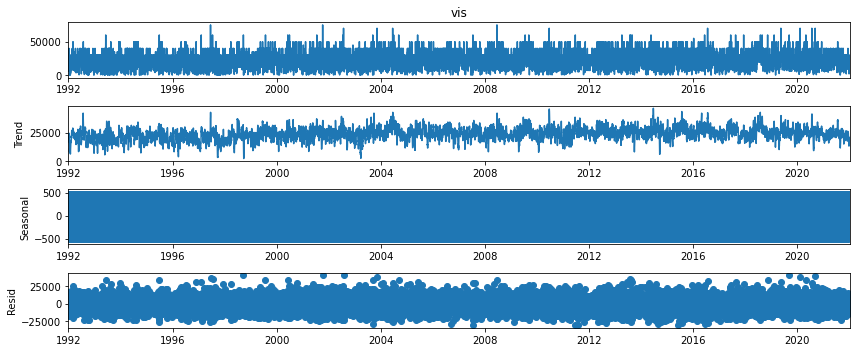

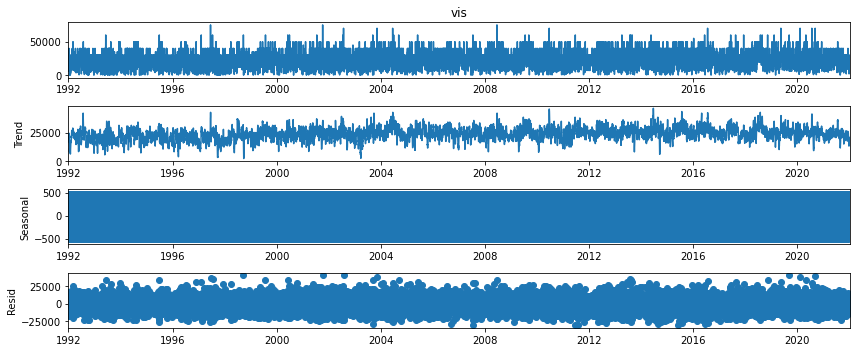

In [55]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,5
result.plot()

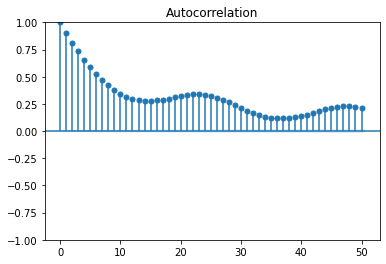

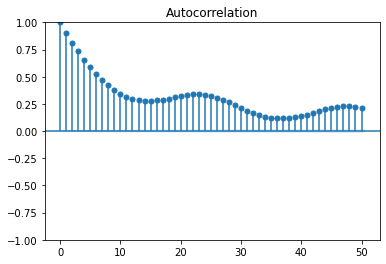

In [54]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
y_acf = y.iloc[:]
plot_acf(y_acf, lags=50)

## 9. Build and train LSTM for Pearson correlation (30 YR) 


A bidirectional LSTM will be trained using datasets with features selected using Mutual Information and Pearson Correlation. Each dataset shall be trained using historical data from 30 years and 7 years for 20 epochs. The forecast date will be held constant to make equal comparsions. Evaluation metrics are MSE and MAPE. LSTM based on procedures presented by Shirzadi (2022) Time Series Analysis and Forecasting with Python (Udemy course) 

In [51]:
#Features selected using Pearson Correlation
Pearson_data_v3 = wx_binned[['wddir','sun','clamt','ww_2','ww_10','w_46','w_50','w_51','ww_58','ww_60','ww_61','w_11','w_22','w_42','w_44','w_52','w_62','w_65','w_66','clht_Cloud 500 to 2000', 'clht_Cloud 5000 above', 'clht_Cloud less than 500','vis']]
Pearson_data_v3

,wddir,sun,clamt,ww_2,ww_10,w_46,w_50,w_51,ww_58,ww_60,...,w_42,w_44,w_52,w_62,w_65,w_66,clht_Cloud 500 to 2000,clht_Cloud 5000 above,clht_Cloud less than 500,vis
0,210.0,0.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,25000
1,220.0,0.0,6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,25000
2,220.0,0.0,6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,25000
3,220.0,0.0,6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,25000
4,230.0,0.0,6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,25000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262988,190.0,0.0,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,20000
262989,100.0,0.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,20000
262990,160.0,0.0,6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20000
262991,180.0,0.0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,25000


In [58]:
train_P = Pearson_data_v3.iloc[:262987,0:23].values #Pearson - independent and dependent variables for training
test_P = Pearson_data_v3.iloc[262987:,0:23].values #Pearson - independent and dependent variables for testing (6 hours)

In [59]:
from sklearn.preprocessing import MinMaxScaler

#Scale data so all features are on the same scale
sc_P30 = MinMaxScaler(feature_range = (0,1))
training_set_scaled_P = sc_P30.fit_transform(train_P)
test_set_scaled_P = sc_P30.fit_transform(test_P)

In [60]:
test_set_scaled_P = test_set_scaled_P[:, 0:22] #Predictors only
test_set_scaled_P.shape

(6, 22)

In [61]:
X_train_P = []
y_train_P = []

WS = 6 #Window size of 6 hours

for i in range(WS, len(training_set_scaled_P)):
  X_train_P.append(training_set_scaled_P[i-WS:i, 0:23]) #Select independent and dependent variables
  y_train_P.append(training_set_scaled_P[i,22:23]) #Select target feature only

X_train_P, y_train_P = np.array(X_train_P), np.array(y_train_P) #Convert to numpy arrays

In [62]:
X_train_P = np.reshape(X_train_P,(X_train_P.shape[0], X_train_P.shape[1], 23))

In [52]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [64]:
Model = Sequential()
#Architecture proposed by Moroney (2021)
Model.add(layers.Bidirectional(layers.LSTM(100, return_sequences=True), input_shape=(X_train_P.shape[1], 23)))
Model.add(Dropout(0.1))
Model.add(layers.Bidirectional(layers.LSTM(100)))
Model.add(Dropout(0.1))
Model.add(layers.Dense(1))

#learning rate decay proposed by Brownlee LRD = LR/EPOCH
#https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/
learning_rate = 0.0001
epochs = 20
decay = learning_rate / epochs

opt = keras.optimizers.Adam(learning_rate=learning_rate, decay=decay) 
Model.compile(optimizer = opt, loss=tf.keras.losses.Huber(), metrics=['mean_squared_error'])

In [65]:
Model.fit(X_train_P, y_train_P, epochs = epochs, batch_size = 32) #Train the model - allow 30 mins

Epoch 1/20
8219/8219 [==============================] - 92s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0093
Epoch 2/20
8219/8219 [==============================] - 88s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0076
Epoch 3/20
8219/8219 [==============================] - 88s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0074
Epoch 4/20
8219/8219 [==============================] - 88s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0072
Epoch 5/20
8219/8219 [==============================] - 87s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0072
Epoch 6/20
8219/8219 [==============================] - 87s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0071
Epoch 7/20
8219/8219 [==============================] - 87s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0071
Epoch 8/20
8219/8219 [==============================] - 86s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0070
Epoch 9/20
8219/8219 [==============================] - 87s 11ms/step - loss: 0.0035 - m

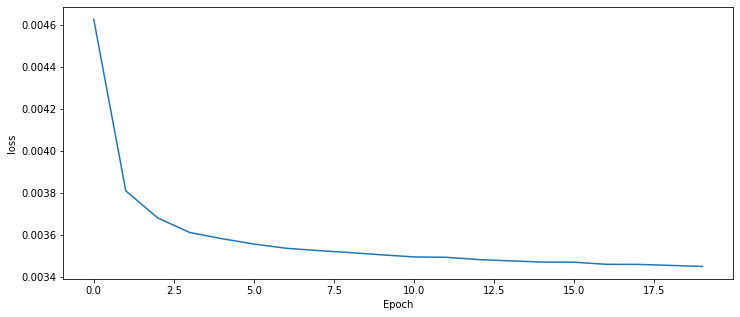

In [66]:
plt.plot(range(len(Model.history.history['loss'])), Model.history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

In [67]:
Model.save('LSTM_pearson')

INFO:tensorflow:Assets written to: LSTM_pearson\assets


INFO:tensorflow:Assets written to: LSTM_pearson\assets


In [68]:
from keras.models import load_model
Model = load_model('LSTM_pearson')

In [69]:
prediction_test = []
Batch_one = training_set_scaled_P[-6:] #First batch is last 6 rows of dataset (6 hours)
Batch_New = Batch_one.reshape(1,6,23) #23 is total number of features including target
#Batch_New

In [70]:
prediction_test = []

Batch_one = training_set_scaled_P[-6:]
Batch_New = Batch_one.reshape((1,6,23))
Batch_New

for i in range(6):
    
    First_pred = Model.predict(Batch_New)[0]
    
    prediction_test.append(First_pred)
    
    New_var = test_set_scaled_P[i,:]
    
    New_var = New_var.reshape(1,22)
    
    New_test = np.insert(New_var, 22, [First_pred], axis =1)
    
    New_test = New_test.reshape(1,1,23)
    
    Batch_New = np.append(Batch_New[:,1:,:], New_test, axis=1)
    
prediction_test = np.array(prediction_test)

In [71]:
prediction_test #Predictions for last 6 hours but need to be reformatted

array([[0.2728331 ],
       [0.277003  ],
       [0.29070565],
       [0.30503532],
       [0.30760235],
       [0.31985748]], dtype=float32)

In [72]:
SI_P301 = MinMaxScaler(feature_range=(0,1))
y_scale = train_P[:,22:23]
SI_P301.fit_transform(y_scale)

array([[0.33328889],
       [0.33328889],
       [0.33328889],
       ...,
       [0.26661777],
       [0.26661777],
       [0.26661777]])

In [73]:
predictions = SI_P301.inverse_transform(prediction_test)
abs(predictions)

array([[20466.12 ],
       [20778.84 ],
       [21806.47 ],
       [22881.123],
       [23073.637],
       [23992.71 ]], dtype=float32)

In [74]:
real_values = test_P[:,22:23] #Last 24 hours of vis data 
real_values

array([[20000.],
       [20000.],
       [20000.],
       [20000.],
       [25000.],
       [25000.]])

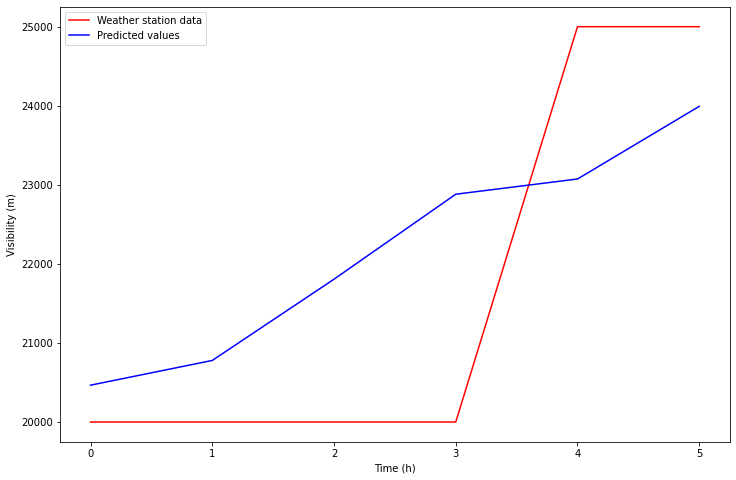

In [75]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,8

plt.plot(real_values, color = 'red', label = 'Weather station data')
plt.plot(predictions, color = 'blue', label = 'Predicted values')

plt.xlabel('Time (h)')
plt.ylabel('Visibility (m)')
plt.legend()
plt.show()

In [76]:
import math
from sklearn.metrics import mean_squared_error
RMSE = math.sqrt(mean_squared_error(real_values,predictions))


def mean_absolute_percentage_error (y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

MAPE = mean_absolute_percentage_error(real_values,predictions)

In [77]:
MAPE

6.899562174479167

In [78]:
RMSE

1688.8641012395049

## 10. Build and train LSTM for Mutual Information dataset (30 yr)

In [79]:
#Features selected using Mutual Information
MI_data = wx_binned[['w_42', 'ww_46', 'w_65', 'ww_44', 'dewpt', 'ww_58', 'w_44', 'w_52', 'clht_Cloud 500 to 2000', 'clamt', 'w_66', 'ww_50', 'w_11', 'clht_Cloud 5000 above', 'ww_61', 'ww_60', 'ww_2', 'w_22', 'ww_10', 'clht_Cloud less than 500', 'sun', 'wdsp', 'w_62', 'clht_Cloud 2000 to 5000', 'wddir', 'vis']]
MI_data

,w_42,ww_46,w_65,ww_44,dewpt,ww_58,w_44,w_52,clht_Cloud 500 to 2000,clamt,...,ww_2,w_22,ww_10,clht_Cloud less than 500,sun,wdsp,w_62,clht_Cloud 2000 to 5000,wddir,vis
0,0,0,0,0,4.3,0,0,0,0,3,...,1,0,0,0,0.0,23,0,0,210.0,25000
1,0,0,0,0,4.0,0,0,0,0,6,...,1,0,0,0,0.0,23,0,0,220.0,25000
2,0,0,0,0,4.5,0,0,0,0,6,...,1,0,0,0,0.0,22,0,0,220.0,25000
3,0,0,0,0,4.8,0,0,0,0,6,...,1,0,0,0,0.0,22,0,1,220.0,25000
4,0,0,0,0,4.8,0,0,0,0,6,...,1,0,0,0,0.0,23,0,1,230.0,25000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262988,0,0,0,0,9.3,0,0,0,0,5,...,1,0,0,0,0.0,10,0,0,190.0,20000
262989,0,0,0,0,9.1,0,0,0,0,4,...,1,0,0,0,0.0,6,0,0,100.0,20000
262990,0,0,0,0,11.0,0,0,0,0,6,...,1,0,0,0,0.0,10,0,1,160.0,20000
262991,0,0,0,0,10.6,0,0,0,0,5,...,0,0,0,0,0.0,13,0,0,180.0,25000


In [80]:
train_MI = MI_data.iloc[:262987,0:26].values #Mutual Information - independent and dependent variables for training
test_MI = MI_data.iloc[262987:,0:26].values #Mutual Information - independent and dependent variables for testing (6 hours)

In [81]:
from sklearn.preprocessing import MinMaxScaler

#Scale data so all features are on the same scale
sc_MI30 = MinMaxScaler(feature_range = (0,1))
training_set_scaled_MI = sc_MI30.fit_transform(train_MI)
test_set_scaled_MI = sc_MI30.fit_transform(test_MI)

In [82]:
test_set_scaled_MI = test_set_scaled_MI[:, 0:25] #Predictors only
test_set_scaled_MI.shape

(6, 25)

In [83]:
X_train_MI = []
y_train_MI = []

WS = 6 # Window size of 24 hours

for i in range(WS, len(training_set_scaled_MI)):
  X_train_MI.append(training_set_scaled_MI[i-WS:i, 0:26]) #Select independent and dependent variables
  y_train_MI.append(training_set_scaled_MI[i,25:26]) #Select target feature only


X_train_MI, y_train_MI = np.array(X_train_MI), np.array(y_train_MI) #Convert to numpy arrays

In [84]:
X_train_MI = np.reshape(X_train_MI,(X_train_MI.shape[0], X_train_MI.shape[1], 26))

In [85]:
Model = Sequential()
#LSTM architecture proposed by Moroney (2021)
Model.add(layers.Bidirectional(layers.LSTM(100, return_sequences=True), input_shape=(X_train_MI.shape[1], 26)))
Model.add(Dropout(0.1))
Model.add(layers.Bidirectional(layers.LSTM(100)))
Model.add(Dropout(0.1))
Model.add(layers.Dense(1))

#learning rate decay formula proposed by Brownlee (2016) 
#https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/
learning_rate = 0.0001
epochs = 20
decay = learning_rate / epochs

opt = keras.optimizers.Adam(learning_rate=learning_rate, decay=decay) 
Model.compile(optimizer = opt, loss=tf.keras.losses.Huber(), metrics=['mean_squared_error'])

In [86]:
Model.fit(X_train_MI, y_train_MI, epochs = epochs, batch_size = 32) #Train the model - allow 30 mins

Epoch 1/20
8219/8219 [==============================] - 93s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0093
Epoch 2/20
8219/8219 [==============================] - 89s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0076
Epoch 3/20
8219/8219 [==============================] - 89s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0074
Epoch 4/20
8219/8219 [==============================] - 89s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0072
Epoch 5/20
8219/8219 [==============================] - 89s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0071
Epoch 6/20
8219/8219 [==============================] - 89s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0071
Epoch 7/20
8219/8219 [==============================] - 89s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0070
Epoch 8/20
8219/8219 [==============================] - 89s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0070
Epoch 9/20
8219/8219 [==============================] - 89s 11ms/step - loss: 0.0035 - m

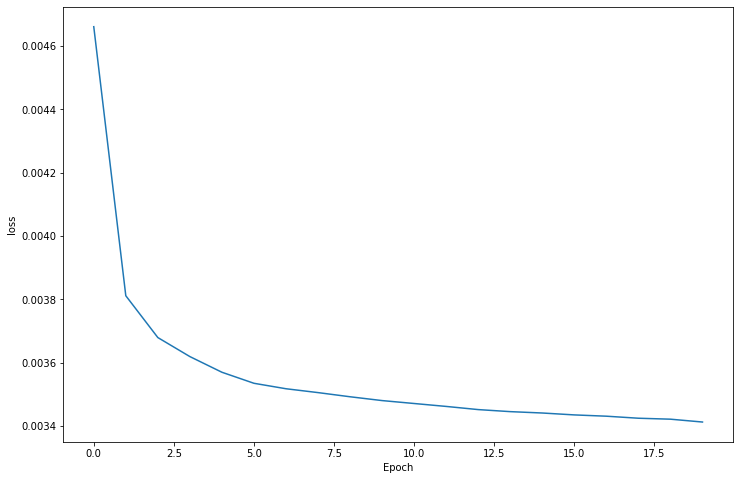

In [87]:
plt.plot(range(len(Model.history.history['loss'])), Model.history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

In [88]:
Model.save('LSTM_MI')

INFO:tensorflow:Assets written to: LSTM_MI\assets


INFO:tensorflow:Assets written to: LSTM_MI\assets


In [89]:
from keras.models import load_model
Model = load_model('LSTM_MI')

In [90]:
prediction_test_MI = []
Batch_one = training_set_scaled_MI[-6:] #First batch is last 6 rows of dataset (6 hours)
Batch_New = Batch_one.reshape(1,6,26) #25 is total number of features including target
#Batch_New

In [91]:
Batch_one = training_set_scaled_MI[-6:]
Batch_New = Batch_one.reshape((1,6,26))
Batch_New

for i in range(6):
    
    First_pred = Model.predict(Batch_New)[0]
    
    prediction_test_MI.append(First_pred)
    
    New_var = test_set_scaled_MI[i,:]
    
    New_var = New_var.reshape(1,25)
    
    New_test = np.insert(New_var, 25, [First_pred], axis =1)
    
    New_test = New_test.reshape(1,1,26)
    
    Batch_New = np.append(Batch_New[:,1:,:], New_test, axis=1)
    
prediction_test = np.array(prediction_test_MI)

In [92]:
prediction_test #Predictions for last 6 hours but need to be reformatted

array([[0.2772196 ],
       [0.33045435],
       [0.39113098],
       [0.45865196],
       [0.3618916 ],
       [0.33835417]], dtype=float32)

In [93]:
SI_MI301 = MinMaxScaler(feature_range=(0,1))
y_scale = train_MI[:,25:26]
SI_MI301.fit_transform(y_scale)

array([[0.33328889],
       [0.33328889],
       [0.33328889],
       ...,
       [0.26661777],
       [0.26661777],
       [0.26661777]])

In [94]:
predictions = SI_MI301.inverse_transform(prediction_test)
abs(predictions)

array([[20795.084],
       [24787.424],
       [29337.867],
       [34401.6  ],
       [27145.06 ],
       [25379.871]], dtype=float32)

In [95]:
real_values = test_MI[:,25:26] #Last 6 hours of vis data 
real_values

array([[20000.],
       [20000.],
       [20000.],
       [20000.],
       [25000.],
       [25000.]])

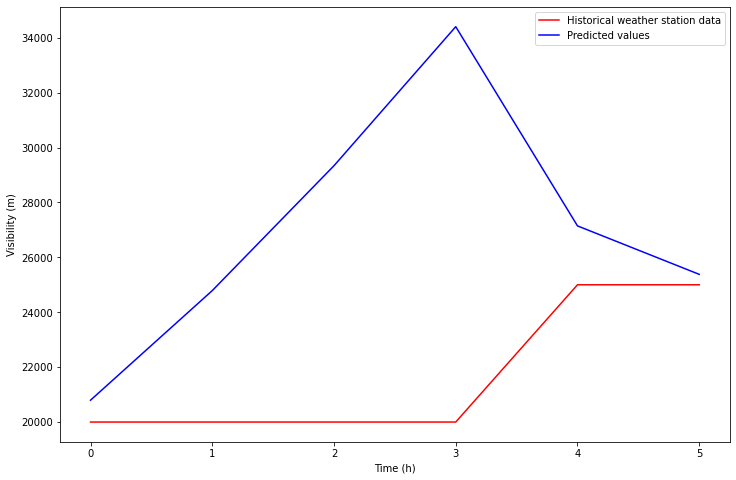

In [96]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,8

plt.plot(real_values, color = 'red', label = 'Historical weather station data')
plt.plot(predictions, color = 'blue', label = 'Predicted values')

plt.xlabel('Time (h)')
plt.ylabel('Visibility (m)')
plt.legend()
plt.show()

In [97]:
import math
from sklearn.metrics import mean_squared_error
RMSE = math.sqrt(mean_squared_error(real_values,predictions))


def mean_absolute_percentage_error (y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

MAPE = mean_absolute_percentage_error(real_values,predictions)

In [98]:
MAPE

26.118268229166663

In [99]:
RMSE

7335.973730259294

## 10. Build and train LSTM for Pearson correlation dataset (7 yr)  

In [100]:
train_P = Pearson_data_v3.iloc[201667:262987,0:23].values #Pearson - 7 years is 61320 hours (262987 -  61320 = 201667)
test_P = Pearson_data_v3.iloc[262987:262993,0:23].values #Pearson -  testing (6 hours)

In [101]:
from sklearn.preprocessing import MinMaxScaler

#Scale data so all features are on the same scale
sc_P7 = MinMaxScaler(feature_range = (0,1))
training_set_scaled_P = sc_P7.fit_transform(train_P)
test_set_scaled_P = sc_P7.fit_transform(test_P)

In [102]:
test_set_scaled_P = test_set_scaled_P[:, 0:22] #Predictors only
test_set_scaled_P.shape

(6, 22)

In [103]:
X_train_P = []
y_train_P = []

WS = 6 # Window size of 24 hours

for i in range(WS, len(training_set_scaled_P)):
  X_train_P.append(training_set_scaled_P[i-WS:i, 0:23]) #Select independent and dependent variables
  y_train_P.append(training_set_scaled_P[i,22:23]) #Select target feature only

X_train_P, y_train_P = np.array(X_train_P), np.array(y_train_P) #Convert to numpy arrays

In [104]:
X_train_P = np.reshape(X_train_P,(X_train_P.shape[0], X_train_P.shape[1], 23))

In [105]:
Model = Sequential()
#Architecture proposed by Moroney (2021)

Model.add(layers.Bidirectional(layers.LSTM(100, return_sequences=True), input_shape=(X_train_P.shape[1], 23)))
Model.add(Dropout(0.1))
Model.add(layers.Bidirectional(layers.LSTM(100)))
Model.add(Dropout(0.1))
Model.add(layers.Dense(1))

#learning rate decay proposed by Brownlee LRD = LR/EPOCH
#https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/

learning_rate = 0.0001
epochs = 20
decay = learning_rate / epochs

opt = keras.optimizers.Adam(learning_rate=learning_rate, decay=decay) 
Model.compile(optimizer = opt, loss=tf.keras.losses.Huber(), metrics=['mean_squared_error'])

In [106]:
Model.fit(X_train_P, y_train_P, epochs = epochs, batch_size = 32) #Train the model - allow 8 mins

Epoch 1/20
1917/1917 [==============================] - 24s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0113
Epoch 2/20
1917/1917 [==============================] - 21s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0080
Epoch 3/20
1917/1917 [==============================] - 21s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0075
Epoch 4/20
1917/1917 [==============================] - 20s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0073
Epoch 5/20
1917/1917 [==============================] - 20s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0071
Epoch 6/20
1917/1917 [==============================] - 20s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0070
Epoch 7/20
1917/1917 [==============================] - 20s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0069
Epoch 8/20
1917/1917 [==============================] - 20s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0068
Epoch 9/20
1917/1917 [==============================] - 20s 11ms/step - loss: 0.0034 - m

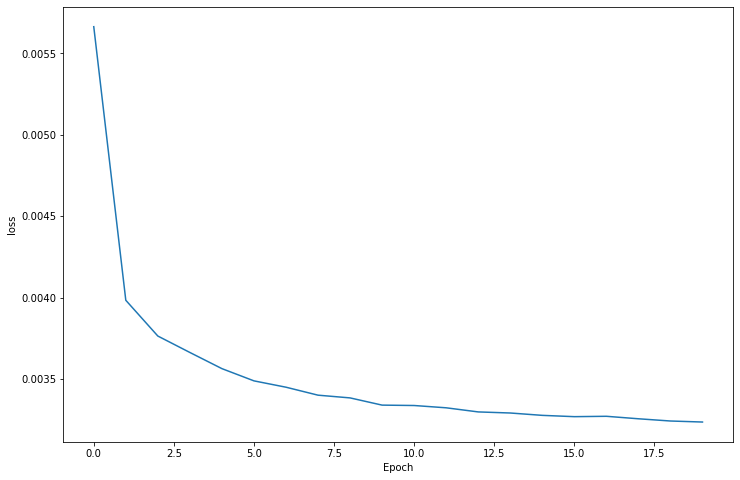

In [107]:
plt.plot(range(len(Model.history.history['loss'])), Model.history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

In [108]:
Model.save('LSTM_pearson_7yr')

INFO:tensorflow:Assets written to: LSTM_pearson_7yr\assets


INFO:tensorflow:Assets written to: LSTM_pearson_7yr\assets


In [109]:
from keras.models import load_model
Model = load_model('LSTM_pearson_7yr')

In [110]:
prediction_test = []
Batch_one = training_set_scaled_P[-6:] #First batch is last 6 rows of dataset (6 hours)
Batch_New = Batch_one.reshape(1,6,23) #23 is total number of features including target
#Batch_New

In [111]:
prediction_test = []

Batch_one = training_set_scaled_P[-6:]
Batch_New = Batch_one.reshape((1,6,23))
Batch_New

for i in range(6):
    
    First_pred = Model.predict(Batch_New)[0]
    
    prediction_test.append(First_pred)
    
    New_var = test_set_scaled_P[i,:]
    
    New_var = New_var.reshape(1,22)
    
    New_test = np.insert(New_var, 22, [First_pred], axis =1)
    
    New_test = New_test.reshape(1,1,23)
    
    Batch_New = np.append(Batch_New[:,1:,:], New_test, axis=1)
    
prediction_test = np.array(prediction_test)

In [112]:
prediction_test #Predictions for last 6 hours but need to be reformatted

array([[0.27322924],
       [0.2713654 ],
       [0.2910574 ],
       [0.308904  ],
       [0.29656082],
       [0.32443565]], dtype=float32)

In [113]:
SI_P71 = MinMaxScaler(feature_range=(0,1))
y_scale = train_P[:,22:23]
SI_P71.fit_transform(y_scale)

array([[0.33244326],
       [0.33244326],
       [0.26568758],
       ...,
       [0.26568758],
       [0.26568758],
       [0.26568758]])

In [114]:
predictions = SI_P71.inverse_transform(prediction_test)
predictions

array([[20564.871],
       [20425.27 ],
       [21900.2  ],
       [23236.908],
       [22312.406],
       [24400.23 ]], dtype=float32)

In [115]:
real_values = test_P[:,22:23] #Last 6 hours of vis data 
real_values

array([[20000.],
       [20000.],
       [20000.],
       [20000.],
       [25000.],
       [25000.]])

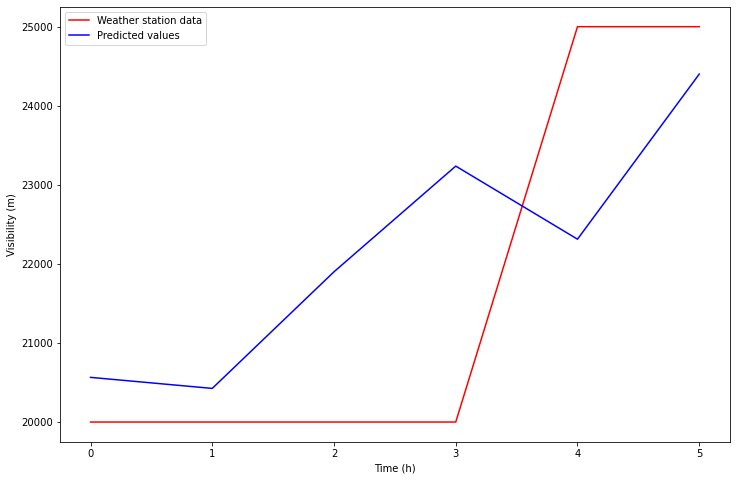

In [116]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,8

plt.plot(real_values, color = 'red', label = 'Weather station data')
plt.plot(predictions, color = 'blue', label = 'Predicted values')

plt.xlabel('Time (h)')
plt.ylabel('Visibility (m)')
plt.legend()
plt.show()

In [117]:
import math
from sklearn.metrics import mean_squared_error
RMSE = math.sqrt(mean_squared_error(real_values,predictions))

def mean_absolute_percentage_error (y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

MAPE = mean_absolute_percentage_error(real_values,predictions)

In [118]:
MAPE

7.297615559895833

In [119]:
RMSE

1922.2880883994665

## 11. Build and train LSTM for Mutual Information dataset (7 yr)

In [120]:
train_MI = MI_data.iloc[201667:262987,0:26].values #Mutual Information - 7 years is 61320 hours (262987 -  61320 = 201667)
test_MI = MI_data.iloc[262987:262993,0:26].values #Mutual Information - testing (6 hours)

In [121]:
from sklearn.preprocessing import MinMaxScaler

#Scale data so all features are on the same scale
sc_MI7 = MinMaxScaler(feature_range = (0,1))
training_set_scaled_MI = sc_MI7.fit_transform(train_MI)
test_set_scaled_MI = sc_MI7.fit_transform(test_MI)

In [122]:
test_set_scaled_MI = test_set_scaled_MI[:, 0:25] #Predictors only
test_set_scaled_MI.shape

(6, 25)

In [123]:
X_train_MI = []
y_train_MI = []

WS = 6 # Window size of 24 hours

for i in range(WS, len(training_set_scaled_MI)):
  X_train_MI.append(training_set_scaled_MI[i-WS:i, 0:26]) #Select independent and dependent variables
  y_train_MI.append(training_set_scaled_MI[i,25:26]) #Select target feature only


X_train_MI, y_train_MI = np.array(X_train_MI), np.array(y_train_MI) #Convert to numpy arrays

In [124]:
X_train_MI = np.reshape(X_train_MI,(X_train_MI.shape[0], X_train_MI.shape[1], 26))

In [125]:
Model = Sequential()
#Architecture proposed by Moroney (2021)
#Model.add(Dropout(0.1))

Model.add(layers.Bidirectional(layers.LSTM(100, return_sequences=True), input_shape=(X_train_MI.shape[1], 26)))
Model.add(Dropout(0.1))
Model.add(layers.Bidirectional(layers.LSTM(100)))
Model.add(Dropout(0.1))

Model.add(layers.Dense(1))

#learning rate decay proposed by Brownlee LRD = LR/EPOCH
#https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/
learning_rate = 0.0001
epochs = 20
decay = learning_rate / epochs

opt = keras.optimizers.Adam(learning_rate=learning_rate, decay=decay) 
Model.compile(optimizer = opt, loss=tf.keras.losses.Huber(), metrics=['mean_squared_error'])

In [126]:
Model.fit(X_train_MI, y_train_MI, epochs = epochs, batch_size = 32) #Train the model - allow 8 mins

Epoch 1/20
1917/1917 [==============================] - 24s 11ms/step - loss: 0.0056 - mean_squared_error: 0.0113
Epoch 2/20
1917/1917 [==============================] - 20s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0080
Epoch 3/20
1917/1917 [==============================] - 20s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0075
Epoch 4/20
1917/1917 [==============================] - 20s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0073
Epoch 5/20
1917/1917 [==============================] - 20s 11ms/step - loss: 0.0036 - mean_squared_error: 0.0072
Epoch 6/20
1917/1917 [==============================] - 20s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0070
Epoch 7/20
1917/1917 [==============================] - 20s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0070
Epoch 8/20
1917/1917 [==============================] - 20s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0068
Epoch 9/20
1917/1917 [==============================] - 20s 11ms/step - loss: 0.0034 - m

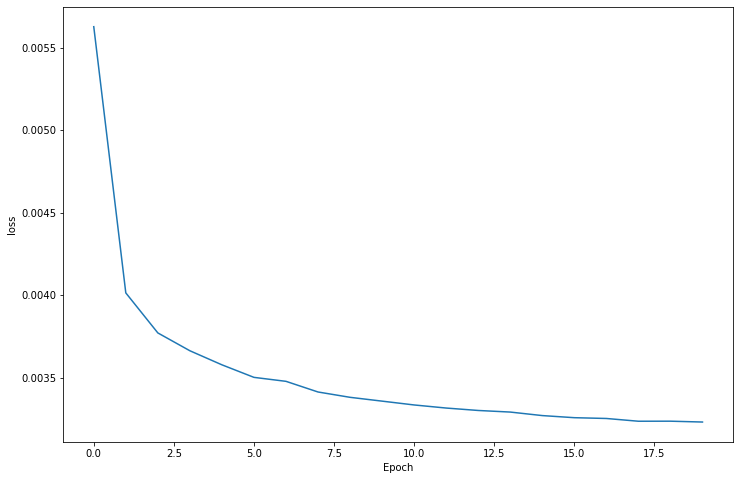

In [127]:
plt.plot(range(len(Model.history.history['loss'])), Model.history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

In [128]:
Model.save('LSTM_MI_7yr')

INFO:tensorflow:Assets written to: LSTM_MI_7yr\assets


INFO:tensorflow:Assets written to: LSTM_MI_7yr\assets


In [129]:
from keras.models import load_model
Model = load_model('LSTM_MI_7yr')

In [130]:
prediction_test_MI = []
Batch_one = training_set_scaled_MI[-6:] #First batch is last 6 rows of dataset (6 hours)
Batch_New = Batch_one.reshape(1,6,26) #26 is total number of features including target
#Batch_New

In [131]:
Batch_one = training_set_scaled_MI[-6:]
Batch_New = Batch_one.reshape((1,6,26))
Batch_New

for i in range(6):
    
    First_pred = Model.predict(Batch_New)[0]
    
    prediction_test_MI.append(First_pred)
    
    New_var = test_set_scaled_MI[i,:]
    
    New_var = New_var.reshape(1,25)
    
    New_test = np.insert(New_var, 25, [First_pred], axis =1)
    
    New_test = New_test.reshape(1,1,26)
    
    Batch_New = np.append(Batch_New[:,1:,:], New_test, axis=1)
    
prediction_test = np.array(prediction_test_MI)

In [132]:
prediction_test #Predictions for last 6 hours but need to be reformatted

array([[0.27898222],
       [0.3144232 ],
       [0.36553648],
       [0.41772488],
       [0.33456707],
       [0.33039275]], dtype=float32)

In [133]:
SI_MI71 = MinMaxScaler(feature_range=(0,1))
y_scale = train_MI[:,25:26]
SI_MI71.fit_transform(y_scale)

array([[0.33244326],
       [0.33244326],
       [0.26568758],
       ...,
       [0.26568758],
       [0.26568758],
       [0.26568758]])

In [134]:
predictions = SI_MI71.inverse_transform(prediction_test)
predictions

array([[20995.768],
       [23650.299],
       [27478.682],
       [31387.594],
       [25159.074],
       [24846.416]], dtype=float32)

In [135]:
real_values = test_MI[:,25:26] #Last 24 hours of vis data 
real_values

array([[20000.],
       [20000.],
       [20000.],
       [20000.],
       [25000.],
       [25000.]])

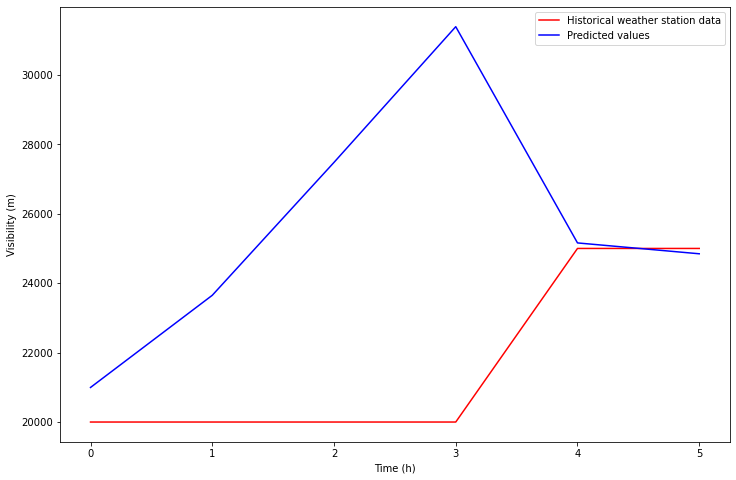

In [136]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,8

plt.plot(real_values, color = 'red', label = 'Historical weather station data')
plt.plot(predictions, color = 'blue', label = 'Predicted values')

plt.xlabel('Time (h)')
plt.ylabel('Visibility (m)')
plt.legend()
plt.show()

In [137]:
import math
from sklearn.metrics import mean_squared_error
RMSE = math.sqrt(mean_squared_error(real_values,predictions))


def mean_absolute_percentage_error (y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

MAPE = mean_absolute_percentage_error(real_values,predictions)

In [138]:
MAPE

19.802056966145834

In [139]:
RMSE

5773.114378283233